1. 데이터 전처리 및 피쳐 추출
- the sequence of packet sizes
[-512,-512,512,-512,…]
- Number of incoming packets


> unmonitored





In [1]:
import pickle
import numpy as np

TOTAL_URLS = 5000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")

with open('./dataset/unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
  x = pickle.load(f)
size = len(x)
print(f'Total samples: {size}')

X_pack_size = [] # Array to store instances (direction*size) - size information
X_num_pack = [] # Array to store the incoming num of packets
y = []

for i in range(TOTAL_URLS):
    size_seq = []
    num_pack = 0
    for c in x[i]:
        dr = 1 if c > 0 else -1
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
        if dr == -1:
            num_pack += 1
    # size_seq = np.pad(size_seq, (0, TOTAL_URLS - len(size_seq)), 'constant')
    X_pack_size.append(size_seq)
    X_num_pack.append(num_pack)
    y.append(-1)

print(len(X_pack_size)) # Print the length of X1



Loading datafile...
Total samples: 10000
5000


> monitored

In [2]:
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("./dataset/mon_standard.pkl", 'rb') as fi: # Path to mon_standard.pkl in Colab
    data = pickle.load(fi)

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        num_pack = 0
        size_seq = []
        for i, c in enumerate(sample):
            dr = 1 if c > 0 else -1
            size_seq.append(dr * 512)
            if dr == -1:
                num_pack += 1
        # size_seq = np.pad(size_seq, (0, max_length - len(size_seq)), 'constant')
        X_pack_size.append(size_seq)
        X_num_pack.append(num_pack)
        y.append(1)

size = len(y)

print(f'Total samples: {size}') # Output: 19000

Loading datafile...
Total samples: 24000


In [3]:
max_length = max(len(arr) for arr in X_pack_size)

# 각 배열의 길이를 최대 길이에 맞춰 늘리고 부족한 부분은 0으로 채웁니다.
def pad_sequence(sequence, max_length):
    return sequence + [0] * (max_length - len(sequence))

X_pack_size_padded = [pad_sequence(arr, max_length) for arr in X_pack_size]

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# 배열로 변환
X_pack_size_array = np.array(X_pack_size_padded)
X_num_pack_array = np.array(X_num_pack).reshape(-1, 1)
X_all = np.concatenate((X_pack_size_array, X_num_pack_array), axis=1)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [5]:
X_train_all

array([[-512, -512,  512, ...,    0,    0, 6903],
       [-512, -512,  512, ...,    0,    0, 1696],
       [-512, -512,  512, ...,    0,    0, 3791],
       ...,
       [-512, -512,  512, ...,    0,    0, 2797],
       [-512, -512,  512, ...,    0,    0,   84],
       [-512, -512,  512, ...,    0,    0, 1508]])

2. 모델 학습
- SVM



In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [7]:
# All feature
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_all, y_train_all)
y_pred_svm = svm_model.predict(X_test_all)
tpr = recall_score(y_test_all, y_pred_svm, average='micro')
precision = precision_score(y_test_all, y_pred_svm, average='micro')
print(f'True Positive Rate: {tpr}')
print(f'False Positive Rate: {1 - tpr}')
print(f'Precision: {precision}')

True Positive Rate: 1.0
False Positive Rate: 0.0
Precision: 1.0


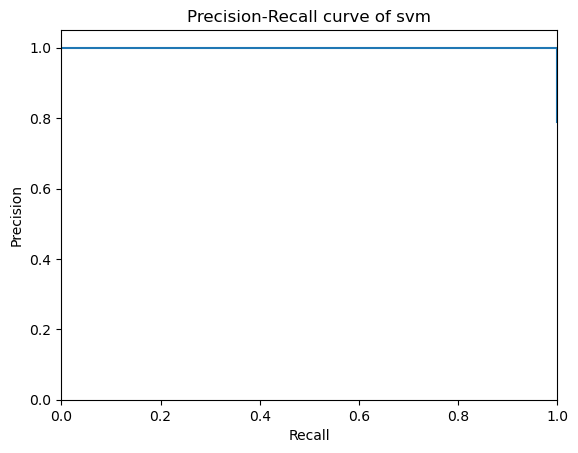

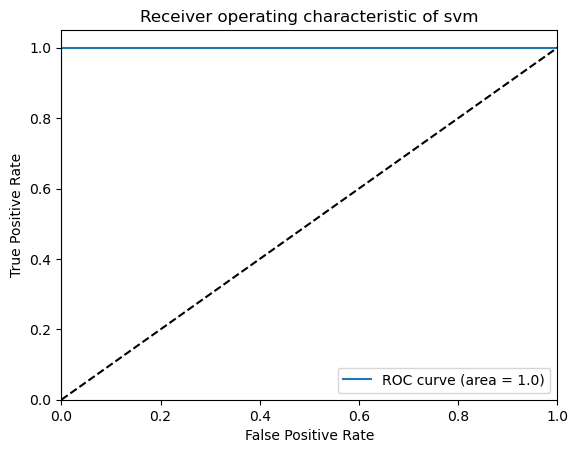

In [8]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_all, y_pred_svm)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_all, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

- random forest

In [9]:
# All feature
rf_model_all = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=1)
rf_model_all.fit(X_train_all, y_train_all)
y_pred_rf_all = rf_model_all.predict(X_test_all)
tpr = recall_score(y_test_all, y_pred_rf_all, average='micro')
precision = precision_score(y_test_all, y_pred_rf_all, average='micro')
print(f'True Positive Rate: {tpr}')
print(f'False Positive Rate: {1 - tpr}')
print(f'Precision: {precision}')

True Positive Rate: 0.96875
False Positive Rate: 0.03125
Precision: 0.96875


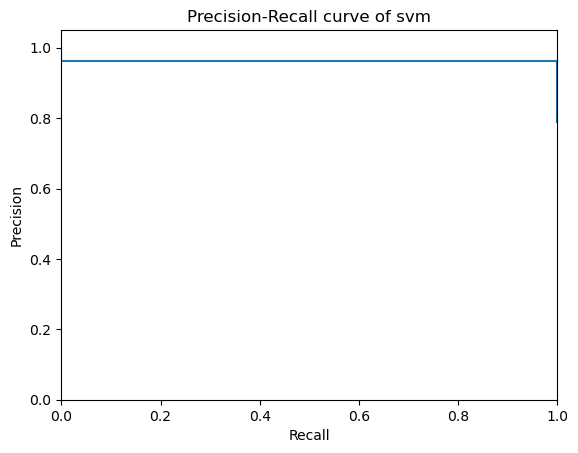

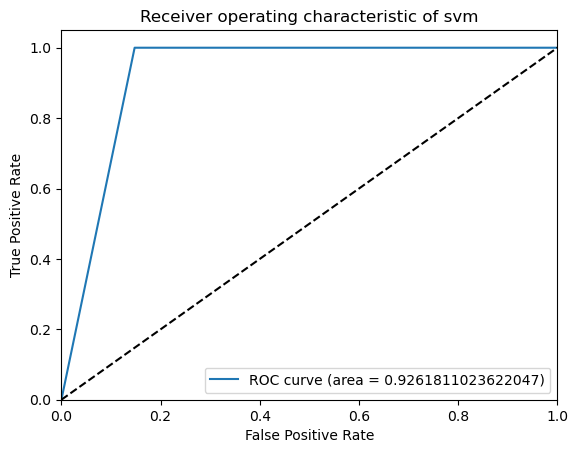

In [15]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_all, y_pred_rf_all)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_all, y_pred_rf_all)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

In [10]:
# All feature
knn_model_all = KNeighborsClassifier(n_neighbors=5)
knn_model_all.fit(X_train_all, y_train_all)
y_pred_knn_all = knn_model_all.predict(X_test_all)
tpr = recall_score(y_test_all, y_pred_knn_all, average='micro')
precision = precision_score(y_test_all, y_pred_knn_all, average='micro')
print(f'True Positive Rate: {tpr}')
print(f'False Positive Rate: {1 - tpr}')
print(f'Precision: {precision}')

True Positive Rate: 0.778125
False Positive Rate: 0.22187500000000004
Precision: 0.778125


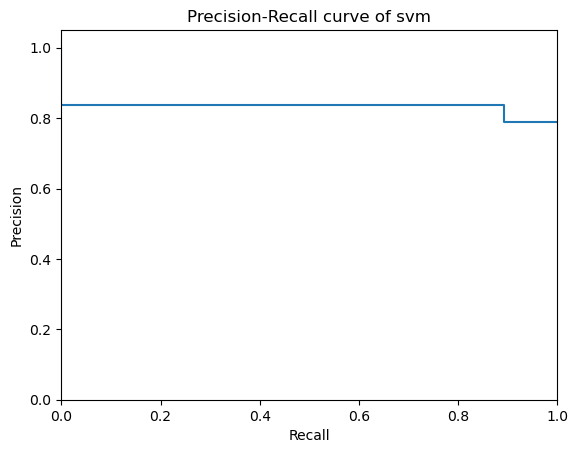

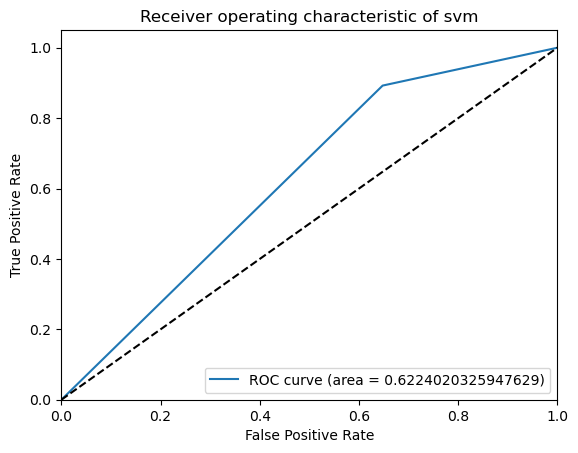

In [16]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_all, y_pred_knn_all)
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve of svm')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_all, y_pred_knn_all)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic of svm')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_all, y_train_all)

best_params_svm = grid_search.best_params_
best_model_svm = grid_search.best_estimator_
y_pred_tuned_svm = best_model_svm.predict(X_test_all)
accuracy_tuned_svm = accuracy_score(y_test_all, y_pred_tuned_svm)
print("Best Parameters:", best_params_svm)
print("Tuned Model Accuracy:", accuracy_tuned_svm)

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {'n_estimators': [20, 50, 100, 200], 'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(rf_model_all, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_all, y_train_all)

best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_
y_pred_tuned_rf = best_model_rf.predict(X_test_all)
accuracy_tuned_rf = accuracy_score(y_test_all, y_pred_tuned_rf)
print("Best Parameters:", best_params_rf)
print("Tuned Model Accuracy:", accuracy_tuned_rf)

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
grid_search = GridSearchCV(knn_model_all, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_all, y_train_all)

best_params_knn = grid_search.best_params_
best_model_knn = grid_search.best_estimator_
y_pred_tuned_knn = best_model_knn.predict(X_test_all)
accuracy_tuned_knn = accuracy_score(y_test_all, y_pred_tuned_knn)
print("Best Parameters:", best_params_knn)
print("Tuned Model Accuracy:", accuracy_tuned_knn)